# Soft Attention MNIST

This is jupyter notebook for `Soft Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
This Algorithm will be tested by `MNIST dataset`

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Parameters

In [3]:
# Parameters 

img_size = 28
img_flat_size = img_size * img_size

# labels: 0 - 9
num_label = 10

num_epoch = 10

# Parameters for optimizer
learning_rate = 5e-4
epsilon = 1e-8

batch_size = 512

# Parameter for LSTM
lstm_size = 512
step_size = img_size
flatten_size = img_size

validation_ratio = 0.1
gpu_fraction = 0.3

# parameter for attention
img_fraction_size = 4
stride = 2

len_horizontal = int((img_size - img_fraction_size) / stride + 1)
len_vertical   = int((img_size - img_fraction_size) / stride + 1)
len_stack = len_horizontal * len_vertical

## Plotting Sample Image

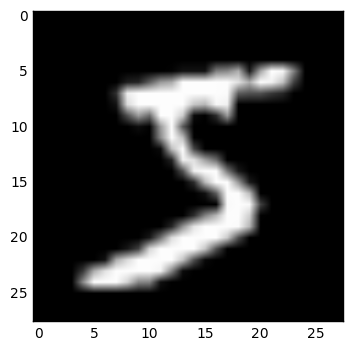

In [4]:
# Plotting example image
img = mnist.train.images[0]
img_resize = img.reshape((img_size, img_size))
plt.imshow(img_resize, cmap = 'gray')
plt.show()

## Plotting Sample Image Fractions

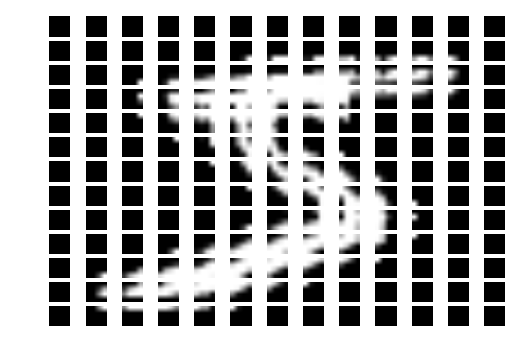

In [5]:
f, ax = plt.subplots(len_vertical, len_horizontal)

img_fraction = np.zeros([img_fraction_size, img_fraction_size, len_stack])
index_fraction = 0
for i in range(len_vertical):
    start_v = stride * i
    for j in range(len_horizontal):
        start_h = stride * j
                
        img_fraction[:,:,index_fraction] = img_resize[start_v : start_v + img_fraction_size, 
                                                      start_h : start_h + img_fraction_size]
        
        ax[i, j].imshow(img_fraction[:,:,index_fraction], cmap = 'gray')
        ax[i, j].axis('off')
        
        index_fraction += 1
        
plt.show()

In [22]:
# Initialize weights and bias 
def weight_variable(shape):
    return tf.Variable(xavier_initializer(shape))

def bias_variable(shape):
	return tf.Variable(xavier_initializer(shape))

# Xavier Weights initializer
def xavier_initializer(shape):
	dim_sum = np.sum(shape)
	if len(shape) == 1:
		dim_sum += 1
	bound = np.sqrt(2.0 / dim_sum)
	return tf.random_uniform(shape, minval=-bound, maxval=bound)

# Convolution and pooling
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

## LSTM function

In [23]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
Wf = tf.Variable(xavier_initializer([flatten_size + lstm_size, lstm_size]))
bf = tf.Variable(xavier_initializer([lstm_size]))
Wi = tf.Variable(xavier_initializer([flatten_size + lstm_size, lstm_size]))
bi = tf.Variable(xavier_initializer([lstm_size]))
Wc = tf.Variable(xavier_initializer([flatten_size + lstm_size, lstm_size]))
bc = tf.Variable(xavier_initializer([lstm_size]))
Wo = tf.Variable(xavier_initializer([flatten_size + lstm_size, lstm_size]))
bo = tf.Variable(xavier_initializer([lstm_size])) 

def LSTM_cell(C_prev, h_prev, x_lstm):
    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf[0]) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi[0]) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc[0]) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo[0]) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c)
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t

## Soft Attention Network!!

In [24]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_fraction_size, img_fraction_size, len_stack])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

x_unstack = tf.unstack(x_image, axis = 3)

# Convolution variables
w_conv1 = weight_variable([2, 2, 1, 64])
b_conv1 = bias_variable([32])

conv_list = []
for i in range(len_stack):
    x_conv = tf.reshape(x_unstack[i], (-1, img_fraction_size, img_fraction_size, 1))
    conv_result = tf.nn.relu(conv2d(x_conv, w_conv1, 2) + b_conv1)
    conv_result_flat = tf.contrib.layers.flatten(conv_result)
    conv_list.append(conv_result_flat)

len_conv = int(conv_list[0].get_shape()[1])

Wa = tf.Variable(xavier_initializer([len_conv, 1]))

m_list = []
for i in range(len(x_unstack)):
    m = tf.tanh(tf.matmul(conv_list[i], Wa))
    m_list.append(m)

m_stack = tf.stack(m_list, axis = 2)
m_stack_reshape = tf.reshape(m_stack, (-1, len_stack))

# Get alpha 
alpha = tf.nn.softmax(m_stack_reshape)

z_list = []

for i in range(len_stack):
    z_list.append(tf.multiply(conv_list[i], tf.slice(alpha, (0, i), (-1, 1))))

z_stack = tf.stack(z_list, axis = 2)
z = tf.reduce_sum(z_stack, axis = 2)

Wz = tf.Variable(xavier_initializer([len_conv, 10]))
bz = tf.Variable(xavier_initializer([10]))

output = tf.nn.softmax(tf.matmul(z, Wz)+bz)

# input_flat = tf.reshape(x_image,[-1, step_size , flatten_size])
# input_unstack = tf.unstack(input_flat, axis = 1)

# rnn_batch_size = tf.shape(input_flat)[0]
# rnn_step_size = tf.shape(input_flat)[1]

# # Initial lstm cell state and output 
# rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
# rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

# #################################### Attention!!! ####################################
# for i in range(len(input_unstack)):
#     rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, input_unstack[i])

# ######################################################################################
# rnn_out = tf.reshape(rnn_out ,shape = [-1, lstm_size])

# # Densely connect layer variables 
# w_fc1 = weight_variable([lstm_size, 256])
# b_fc1 = bias_variable([256])

# w_fc2 = weight_variable([256, num_label])
# b_fc2 = bias_variable([num_label])

# # Fully Connected Layer
# h_fc1 = tf.nn.relu(tf.matmul(rnn_out, w_fc1)+b_fc1)
# output = tf.matmul(h_fc1, w_fc2)+b_fc2

# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Making Dataset

In [25]:
# Dataset for train, test, validation

test_len = mnist.test.images.shape[0]
validation_len = int(test_len * validation_ratio)

train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y = mnist.train.labels
test_y = mnist.test.labels[validation_len : test_len]
validation_y = mnist.test.labels[ : validation_len]

print("Training set: " + str(train_x.shape))
print("Testing set: " + str(test_x.shape))
print("Validation set: " + str(validation_x.shape))

Training set: (60000, 784)
Testing set: (9000, 784)
Validation set: (1000, 784)


## Create Session

In [26]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

data = np.insert(train_x, img_flat_size, train_y, axis = 1)
len_data = data.shape[0]

## Training

In [27]:
# Training
for i in range(num_epoch):
    np.random.shuffle(data)

    data_x = data[:, :img_flat_size]
    data_y = data[:, img_flat_size]

    data_y_onehot = np.zeros([data_y.shape[0], num_label])
    for j in range(data_y.shape[0]):
        data_y_onehot[j, int(data_y[j])] = 1
    
    data_y_onehot_val = np.zeros([validation_y.shape[0], num_label])
    for j in range(validation_y.shape[0]):
        data_y_onehot_val[j, int(validation_y[j])] = 1
        
    batch_count = 1
    for j in range(0, len_data, batch_size):
        if j + batch_size < len_data:
            data_x_in = data_x[j : j + batch_size, :]
            data_y_in = data_y_onehot[j : j + batch_size, :]
        else:
            data_x_in = data_x[j : len_data, :]
            data_y_in = data_y_onehot[j : len_data, :]
        
        
        data_x_in_resize = np.reshape(data_x_in, (data_x_in.shape[0], img_size, img_size))
                                      
        img_fraction = np.zeros([data_x_in.shape[0], img_fraction_size, img_fraction_size, len_stack])
                                      
        index_fraction = 0
        for m in range(len_vertical):
            start_v = stride * m
            for n in range(len_horizontal):
                start_h = stride * n

                img_fraction[:,:,:,index_fraction] = data_x_in_resize[:, 
                                                                      start_v : start_v + img_fraction_size, 
                                                                      start_h : start_h + img_fraction_size]
                index_fraction += 1
        
        optimizer.run(feed_dict = {x_image: img_fraction, y_target: data_y_in})
        cost = sess.run(Cost, feed_dict = {x_image: img_fraction, y_target: data_y_in})
        acc = sess.run(accuracy, feed_dict = {x_image: img_fraction, y_target: data_y_in})
                                      
        print("Epoch: " + str(i+1) + ' / ' + "Batch: " + str(j) + '/' + str(len_data) + ' / ' + "Cost: " + str(cost) + ' / ' + \
              "Training Accuracy: " + str(acc))
#         val_acc = sess.run(accuracy, feed_dict = {x_image: validation_x, y_target: data_y_onehot_val})
        
#         print("Epoch: " + str(i+1) + ' / ' + "Batch: " + str(j) + '/' + str(len_data) + ' / ' + "Cost: " + str(cost) + ' / ' + \
#               "Training Accuracy: " + str(acc) + ' / ' + "Validation Accuracy: " + str(val_acc))

Epoch: 1 / Batch: 0/60000 / Cost: 0.73434 / Training Accuracy: 0.105469
Epoch: 1 / Batch: 512/60000 / Cost: 0.734473 / Training Accuracy: 0.101563
Epoch: 1 / Batch: 1024/60000 / Cost: 0.734384 / Training Accuracy: 0.103516
Epoch: 1 / Batch: 1536/60000 / Cost: 0.734361 / Training Accuracy: 0.115234
Epoch: 1 / Batch: 2048/60000 / Cost: 0.734449 / Training Accuracy: 0.111328
Epoch: 1 / Batch: 2560/60000 / Cost: 0.734583 / Training Accuracy: 0.0839844
Epoch: 1 / Batch: 3072/60000 / Cost: 0.734399 / Training Accuracy: 0.125
Epoch: 1 / Batch: 3584/60000 / Cost: 0.734409 / Training Accuracy: 0.0976563
Epoch: 1 / Batch: 4096/60000 / Cost: 0.73449 / Training Accuracy: 0.111328
Epoch: 1 / Batch: 4608/60000 / Cost: 0.734348 / Training Accuracy: 0.111328
Epoch: 1 / Batch: 5120/60000 / Cost: 0.734442 / Training Accuracy: 0.107422
Epoch: 1 / Batch: 5632/60000 / Cost: 0.734401 / Training Accuracy: 0.0898438
Epoch: 1 / Batch: 6144/60000 / Cost: 0.734346 / Training Accuracy: 0.0859375
Epoch: 1 / Batch:

## Testing

In [ ]:
# Testing

test_y_onehot = np.zeros([test_y.shape[0], num_label])
for i in range(test_y.shape[0]):
    test_y_onehot[i, int(test_y[i])] = 1

test_result = sess.run(output, feed_dict = {x_image: test_x, rnn_batch_size: test_x.shape[0], rnn_step_size: step_size})

count_correct = 0
for i in range(test_result.shape[0]):
    prediction_y = np.argmax(test_result[i,:])
    
    if prediction_y == test_y[i]:
        count_correct += 1

test_acc = count_correct / test_result.shape[0]

print("Test Accuracy: " + str(test_acc))